# Exploratory Data Analysis
### Kwame V. Taylor

## Set up Environment

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# default viz size settings
plt.rc('figure', figsize=(11, 8))
plt.rc('font', size=15)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

In [2]:
from prepare import handle_nulls
from preprocessing import split_df, scale_data

## Acquire data

In [3]:
df = pd.read_csv('full_playlist_offset.csv', index_col=0)

In [4]:
df.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,explicit,popularity
0,Tay-K,TRAPMAN,TRAPMAN,6mecZbKK3JDeMdFRNxsCV5,0.792,0.594,2,-8.544,1,0.3000,0.000000,0.244,0.351,82.512,232803,4,2020-07-12,True,43.0
1,Lil Wyte,Doubt Me Now,Oxy Cotton,5PtMwNq8Dp31uYdGGacVJE,0.816,0.578,9,-6.912,1,0.2330,0.000000,0.114,0.265,148.077,193920,4,2003-03-04,True,61.0
2,Kamelen,KINGPIN SLIM,Kingpin O.G - Remix,6s8EhlBn2PIoESylkXnwYc,0.649,0.798,0,-6.450,0,0.1450,0.000000,0.409,0.717,160.011,254390,4,2019-11-29,True,22.0
3,Waka Flocka Flame,Flockaveli,Grove St. Party (feat. Kebo Gotti),2e9EZ2V5QGGZPMJacO3y0Y,0.705,0.702,0,-4.783,0,0.1080,0.000000,0.364,0.771,140.059,250493,4,2010-10-01,True,62.0
4,Project Pat,Mista Don't Play: Everythangs Workin',Don't Save Her (feat. Crunchy Black),3ZRd5Z0fiYtASLdEPPb16m,0.838,0.793,11,-5.470,0,0.0773,0.000001,0.106,0.800,160.003,261933,4,2001-02-13,True,45.0


In [5]:
df.shape

(700, 19)

## Prepare data

In [6]:
# handle null values
df = handle_nulls(df)

# split the data
train, validate, test = split_df(df)
train.head()

train shape:  (491, 19) , validate shape:  (139, 19) , test shape:  (70, 19)

train percent:  70.0 , validate percent:  20.0 , test percent:  10.0


,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,explicit,popularity
534,Dem Franchize Boyz,Dem Franchize Boyz,Oh I Think Dey Like Me,2T31osJ8UyFAXwLH9QW1kr,0.846,0.651,7,-10.007,1,0.334,0.0,0.0580,0.721,83.020,273880,4,2004-01-01,True,40.0
94,Fat Joe,All Or Nothing,"Lean Back (feat. Lil Jon, Eminem, Mase & Remy ...",2uiEqPjMmIJXOKplzsEASP,0.635,0.751,1,-5.055,0,0.357,0.0,0.0951,0.591,126.806,289739,5,2005-06-14,True,62.0
421,Lil Jon & The East Side Boyz,Crunk Juice,Get Crunk,39jxVaEhI8R7csdu7GAjmL,0.524,0.974,1,-3.807,1,0.553,0.0,0.6190,0.603,78.131,257853,4,2004-11-16,True,38.0
646,D4L,Down For Life,Betcha Can't Do It Like Me,1KW8BTLgbRCTH8pzUmboLE,0.901,0.359,10,-8.198,0,0.248,0.0,0.0752,0.219,149.019,220467,4,2005-11-08,True,42.0
677,Paul Wall,slab god,Hold It Diine 4 My City (feat. Scotty ATL & Pr...,3z29t85OGZHHhMcMMgWMoO,0.649,0.669,9,-5.911,1,0.237,0.0,0.1850,0.460,84.954,230587,4,2015-09-25,True,29.0


In [7]:
df.columns

Index(['artist', 'album', 'track_name', 'track_id', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'release_date', 'explicit', 'popularity'],
      dtype='object')

# Does a track being explicit or not correlate with its popularity?

### Swarm plot

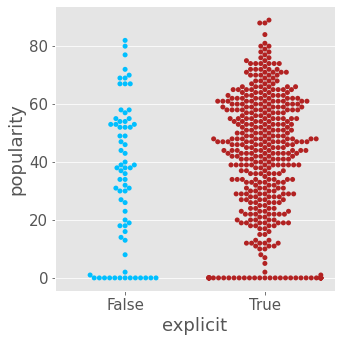

In [8]:
sns.catplot(x="explicit", y="popularity", kind="swarm", data=train)

### Independent T-Test

The features are independent because there is no overlap between observations in explicit and observations in not explicit.

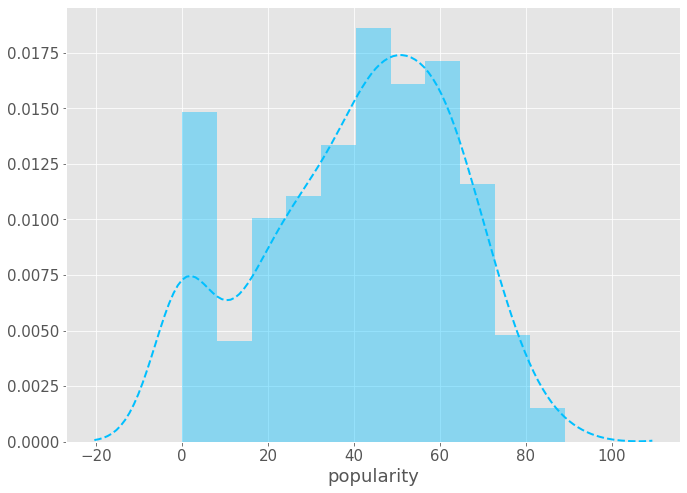

In [9]:
# check for normal distribution
sns.distplot(train.popularity)

In [10]:
train.explicit.value_counts()

True     421
False     70
Name: explicit, dtype: int64

In [11]:
# compare variances
explicit_sample = train[train.explicit==True].popularity
not_explicit_sample = train[train.explicit==False].popularity

print(explicit_sample.var())
print(not_explicit_sample.var())

469.53165931455715
599.9014492753624


No, so we will set the argument of equal_var to False.

**Set hypothesis and alpha:**

$H_{0}$: Mean of song popularity of explicit tracks = Mean of song popularity of non-explicit tracks

$H_{a}$: Mean of song popularity of explicit tracks > Mean of song popularity of non-explicit tracks

$\alpha$: .05

In [12]:
alpha = .05

**Compute test statistic and probability (t-statistic & p-value)**

In [13]:
t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = False)

print('Test statistic:', t, '\n', p/2, '\n', alpha)

Test statistic: 2.350933427608353 
 0.010481876446442058 
 0.05


**Decide**

In [14]:
null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."

if p/2 < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.


In [15]:
not_explicit_sample.mean(), explicit_sample.mean()

(34.8, 42.11638954869359)

Now put it in a function:

In [16]:
def explicit_viz(df):
    '''
    This function produces a swarm plot on explicit tracks' and non-explicit tracks' popularity.
    '''
    print('Does a track being explicit or not correlate with its popularity?')
    sns.catplot(x="explicit", y="popularity", kind="swarm", data=df)

In [17]:
def explicit_ttest(df, alpha):
    print('Set the alpha/significance level:')
    print('  alpha =', alpha)
    
    print('\n---\n')
    
    print('Check for normal distribution:')
    sns.distplot(df.popularity)
    plt.show()
    
    print('---\n')
    
    print('Check values counts:')
    print(df.explicit.value_counts())
    
    print('\n---\n')
    
    print('Compare variances:')
    explicit_sample = df[df.explicit==True].popularity
    not_explicit_sample = df[df.explicit==False].popularity

    print(explicit_sample.var())
    print(not_explicit_sample.var())
          
    print("They are not equal, so we will set the argument of equal_var to False.")
    
    print('\n---\n')
          
    print("Compute test statistic and probability (t-statistic & p-value)")
    t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = False)
    print('Test statistic:', t, '\np-value:', p/2, '\nalpha:', alpha)
    
    print('\n---\n')
    
    null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."
    if p/2 < alpha:
        print("We reject the hypothesis that", null_hypothesis)
    else:
        print("We fail to reject the null hypothesis.")
        
    print('\n---\n')
          
    print('mean of non-explicit songs:', not_explicit_sample.mean(), '\nmean of explicit songs:', explicit_sample.mean())

Set the alpha/significance level:
  alpha = 0.05

---

Check for normal distribution:


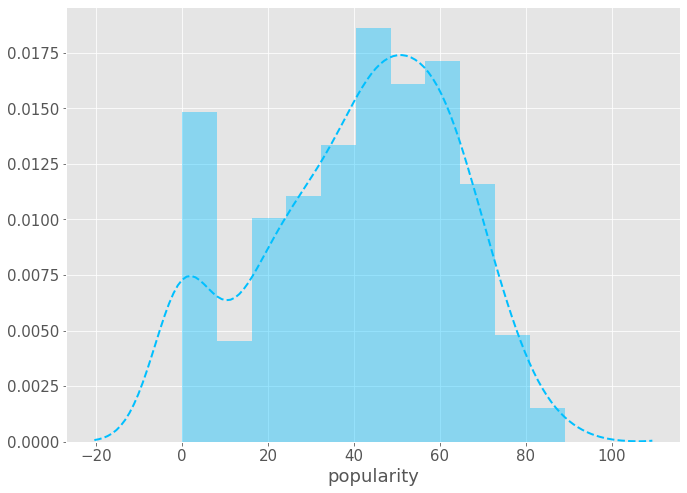

---

Check values counts:
True     421
False     70
Name: explicit, dtype: int64

---

Compare variances:
469.53165931455715
599.9014492753624
They are not equal, so we will set the argument of equal_var to False.

---

Compute test statistic and probability (t-statistic & p-value)
Test statistic: 2.350933427608353 
p-value: 0.010481876446442058 
alpha: 0.05

---

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.

---

mean of non-explicit songs: 34.8 
mean of explicit songs: 42.11638954869359


In [18]:
explicit_ttest(train, alpha)

# Does loudness have a relationship with popularity?

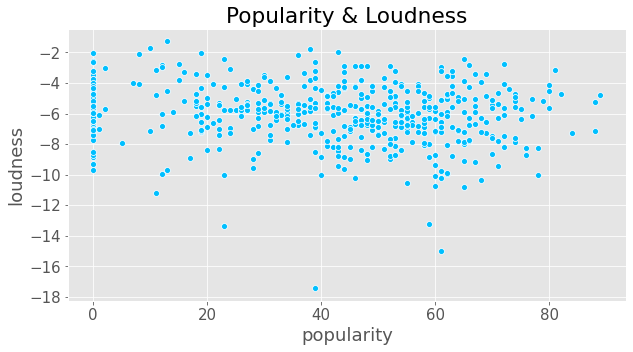

In [21]:
plt.figure(figsize=(10,5))
plt.title('Popularity & Loudness')
plt.ylabel('Loudness')
plt.xlabel('Popularity')
sns.scatterplot(train['popularity'], train['loudness'])
plt.show()

Doesn't appear to be any valuable insights here.

# Are originals or remixes more popular?

In [22]:
train[train.track_name.str.contains('Remix', case=True, flags=0, regex=False)]

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,explicit,popularity
94,Fat Joe,All Or Nothing,"Lean Back (feat. Lil Jon, Eminem, Mase & Remy ...",2uiEqPjMmIJXOKplzsEASP,0.635,0.751,1,-5.055,0,0.3570,0.000000,0.0951,0.591,126.806,289739,5,2005-06-14,True,62.0
154,Raekwon,Only Built 4 Cuban Linx...,"Wu-Gambinos (feat. Ghostface Killah, Method Ma...",5byHoShbSK7mxLGDQZli9J,0.706,0.687,9,-4.301,0,0.3400,0.000162,0.0830,0.493,99.034,339507,4,1995-01-01,True,39.0
576,Yo Gotti,Live From The Kitchen,"5 Star Remix (feat. Gucci Mane, Trina & Nicki ...",3yikbrpdkxkVyDo6bdv9D3,0.771,0.761,9,-5.844,1,0.2560,0.000000,0.2740,0.603,76.476,244293,4,2012-01-06,True,31.0
301,Kanye West,Nah Nah Nah (feat. DaBaby & 2 Chainz) [Remix],Nah Nah Nah (feat. DaBaby & 2 Chainz) - Remix,20m8ZHA6Jevqo1xnhQffQu,0.733,0.743,2,-5.045,1,0.3710,0.000000,0.2610,0.623,150.024,191353,4,2020-11-13,False,77.0
669,Young Dro,We In Da City Remix (feat. T.I.),We In Da City Remix (feat. T.I.),16f9CLcDuSTYiLA8AeTlHd,0.675,0.773,1,-3.232,0,0.0713,0.000000,0.0865,0.341,140.011,275529,4,2015-07-10,True,0.0
649,Huey,Notebook Paper,"Pop, Lock & Drop It (feat. Bow Wow & T-Pain) -...",2smQB1lhS08j7Rkt16rXBb,0.802,0.689,0,-6.264,1,0.3430,0.000000,0.4150,0.838,144.096,269973,4,2007-06-19,True,29.0
265,Young Thug,Hot (Remix) [feat. Gunna and Travis Scott],Hot (Remix) [feat. Gunna and Travis Scott],56AMYGJzxBO6p8v0wEe9de,0.845,0.631,7,-8.206,0,0.2160,0.000000,0.0806,0.545,111.983,279907,4,2019-11-01,True,72.0
2,Kamelen,KINGPIN SLIM,Kingpin O.G - Remix,6s8EhlBn2PIoESylkXnwYc,0.649,0.798,0,-6.450,0,0.1450,0.000000,0.4090,0.717,160.011,254390,4,2019-11-29,True,22.0
681,Various Artists,It's the King Bitch,Ain't I (Remix),0CAh5ReeIyCizdQrZHPG9v,0.514,0.838,11,-5.353,1,0.0649,0.000000,0.5930,0.324,77.491,224427,4,2012-01-03,True,36.0
639,Gucci Mane,Trap-A-Thon,Freaky Gurl - Remix,3Q1KlH4ITZWpxKGWmsdEAN,0.679,0.711,7,-2.827,1,0.1610,0.000000,0.3590,0.587,73.486,215560,4,2007-09-25,True,12.0


In [23]:
train[train.track_name.str.contains('Pop, Lock', case=True, flags=0, regex=False)]

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,explicit,popularity
649,Huey,Notebook Paper,"Pop, Lock & Drop It (feat. Bow Wow & T-Pain) -...",2smQB1lhS08j7Rkt16rXBb,0.802,0.689,0,-6.264,1,0.343,0.0,0.415,0.838,144.096,269973,4,2007-06-19,True,29.0
38,Huey,Notebook Paper,"Pop, Lock & Drop It (feat. Bow Wow & T-Pain) -...",6nbRXoZJAWlHtnWcPAY9Or,0.802,0.689,0,-6.264,1,0.343,0.0,0.415,0.838,144.096,269973,4,2006-01-01,True,46.0
41,Huey,"Pop, Lock & Drop It","Pop, Lock & Drop It",19UUPNx5jccGgQ2GCIZkww,0.745,0.568,0,-8.332,1,0.164,0.0,0.159,0.494,144.142,263240,4,2006-09-19,True,51.0


There are not enough remixes and originals to compare.

# What are the drivers of popularity?

In [32]:
def corr_heatmap(train_scaled):
    '''
    This function creates a heatmap of the correlation of all features scaled, minus longitude and latitude and redundant features.
    Takes a dataFrame as an argument
    '''
    # heatmap time!
    heatmap_data = train_scaled
    corr = heatmap_data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    ax = sns.heatmap(corr, mask=mask, center=0, vmin=0, vmax=1, cmap=sns.diverging_palette(95, 220, n=250, s=93, l=35), square=True) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    plt.title('Which features have significant correlation?')
    ax

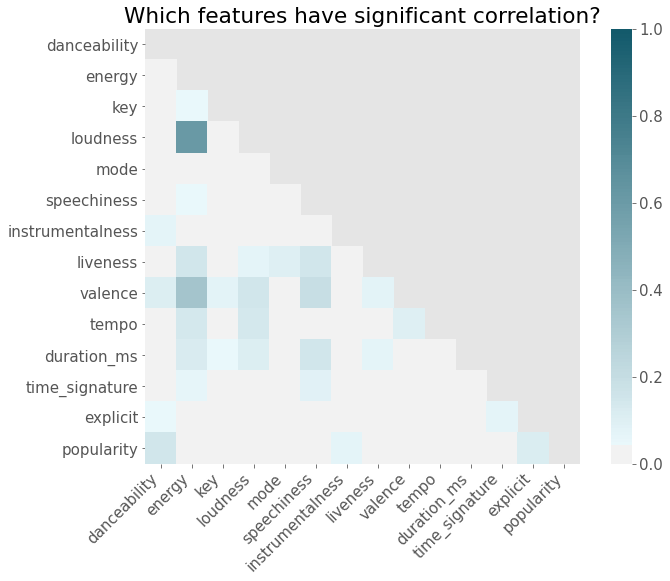

In [33]:
corr_heatmap(train.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date']))

In [34]:
import sklearn.preprocessing
    
train_scaled = train.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date'])
validate_scaled = validate.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date'])
test_scaled = test.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date'])
    
scaler = sklearn.preprocessing.MinMaxScaler()
        
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(train_scaled)

# transforming all three dfs with the scaler object
# this turns it into an array
train_scaled = scaler.transform(train_scaled)
validate_scaled = scaler.transform(validate_scaled)
test_scaled = scaler.transform(test_scaled)

# converting scaled array back to df
# first by converting to a df, it will not have the original index and column names
train_scaled = pd.DataFrame(train_scaled)
validate_scaled = pd.DataFrame(validate_scaled)
test_scaled = pd.DataFrame(test_scaled)
        
# setting index to original dfs
train_scaled.index = train.index
validate_scaled.index = validate.index
test_scaled.index = test.index
        
# renaming columns to original dfs
train_scaled.columns = train.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date']).columns
validate_scaled.columns = validate.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date']).columns
test_scaled.columns = test.drop(columns=['artist', 'album', 'track_name', 'track_id', 'release_date']).columns

In [35]:
train_scaled

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity
534,0.800000,0.510606,0.636364,0.460101,1.0,0.424142,0.000000,0.035179,0.725675,0.172623,0.545727,0.5,1.0,0.449438
94,0.465079,0.662121,0.090909,0.766423,0.0,0.455980,0.000000,0.078254,0.586369,0.511401,0.591548,1.0,1.0,0.696629
421,0.288889,1.000000,0.090909,0.843622,1.0,0.727298,0.000000,0.686520,0.599228,0.134796,0.499421,0.5,1.0,0.426966
646,0.887302,0.068182,0.909091,0.572003,0.0,0.305094,0.000000,0.055149,0.187741,0.683265,0.391402,0.5,1.0,0.471910
677,0.487302,0.537879,0.818182,0.713473,1.0,0.289867,0.000000,0.182631,0.445992,0.187587,0.420642,0.5,1.0,0.325843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.698413,0.478788,0.090909,0.727576,1.0,0.186047,0.000000,0.143156,0.269181,0.137775,0.496378,0.5,1.0,0.584270
262,0.784127,0.392424,0.090909,0.675430,0.0,0.281561,0.000000,0.066411,0.380626,0.659365,0.209395,0.5,1.0,0.606742
187,0.841270,0.596970,0.000000,0.680255,1.0,0.046788,0.000336,0.341693,0.502786,0.389193,0.297573,0.5,1.0,0.550562
430,0.914286,0.636364,1.000000,0.903934,0.0,0.334164,0.000019,0.189597,0.604586,0.281128,0.420948,0.5,1.0,0.741573


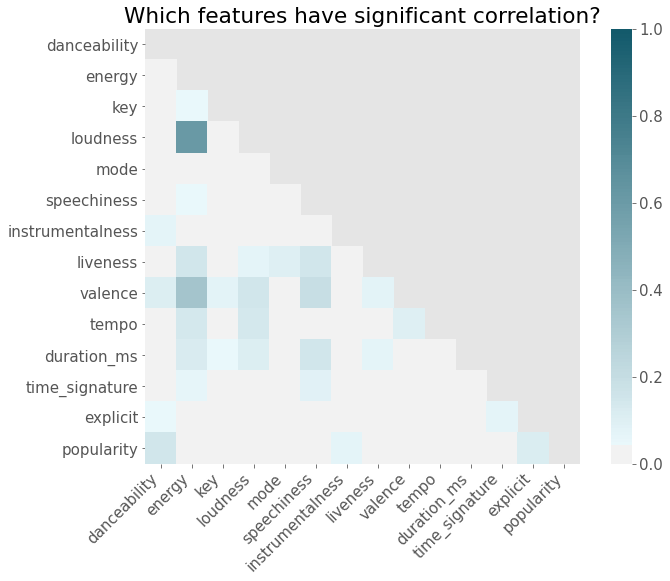

In [36]:
corr_heatmap(train_scaled)

Turns out the scaling didn't make a difference. Whoops.

Looks like the top drivers of popularity across all of the tracks are danceability, instrumentalness, and explicit.

# Do instrumentals/lyrics have an effect on popularity?

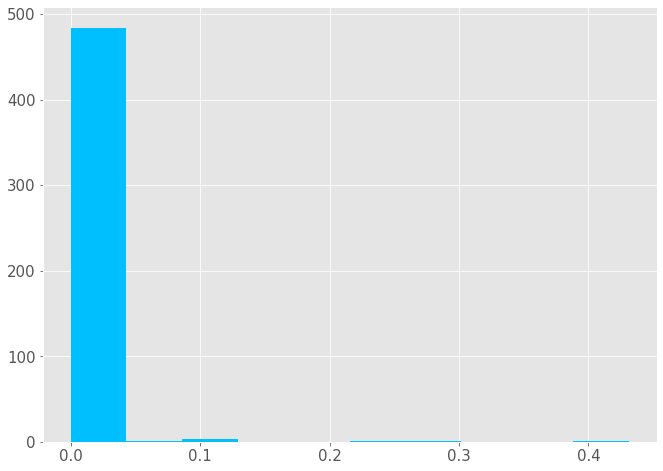

In [38]:
train.instrumentalness.hist()

In [39]:
train.instrumentalness.value_counts()

0.000000    373
0.000001      2
0.000009      2
0.000001      2
0.000002      2
           ... 
0.000006      1
0.001410      1
0.000050      1
0.000003      1
0.000005      1
Name: instrumentalness, Length: 114, dtype: int64

In [40]:
train.instrumentalness.max()

0.431

In [42]:
train['instrumentalness_boolean'] = train["instrumentalness"] > 0.0
train.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,explicit,popularity,instrumentalness_boolean
534,Dem Franchize Boyz,Dem Franchize Boyz,Oh I Think Dey Like Me,2T31osJ8UyFAXwLH9QW1kr,0.846,0.651,7,-10.007,1,0.334,0.0,0.0580,0.721,83.020,273880,4,2004-01-01,True,40.0,False
94,Fat Joe,All Or Nothing,"Lean Back (feat. Lil Jon, Eminem, Mase & Remy ...",2uiEqPjMmIJXOKplzsEASP,0.635,0.751,1,-5.055,0,0.357,0.0,0.0951,0.591,126.806,289739,5,2005-06-14,True,62.0,False
421,Lil Jon & The East Side Boyz,Crunk Juice,Get Crunk,39jxVaEhI8R7csdu7GAjmL,0.524,0.974,1,-3.807,1,0.553,0.0,0.6190,0.603,78.131,257853,4,2004-11-16,True,38.0,False
646,D4L,Down For Life,Betcha Can't Do It Like Me,1KW8BTLgbRCTH8pzUmboLE,0.901,0.359,10,-8.198,0,0.248,0.0,0.0752,0.219,149.019,220467,4,2005-11-08,True,42.0,False
677,Paul Wall,slab god,Hold It Diine 4 My City (feat. Scotty ATL & Pr...,3z29t85OGZHHhMcMMgWMoO,0.649,0.669,9,-5.911,1,0.237,0.0,0.1850,0.460,84.954,230587,4,2015-09-25,True,29.0,False


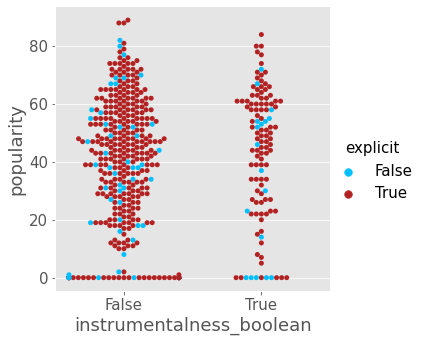

In [43]:
sns.catplot(x="instrumentalness_boolean", y="popularity", hue="explicit", kind="swarm", data=train)

There doesn't appear to be a significant difference in popularity between songs with a 0.0 amount of instrumentalness, and songs that have over 0.0 amount of instrumentalness.